# Practical Unit 2

## Pipeline Overview

1. **Initialize Setup**
    - `seed`, `device`, ...
2. **Load datasets**
    - same transformation, augmentation, ... for pre-training and fine-tuning
3. **Build CoAtNet**
    - adjust for pre-training and fine-tuning accordingly 
4. **Pre-Training**
    - Train-Loop
    - Evaluation
    - Save best pre-trained Model
5. **Fine-Tuning**
    - Train-Loop
    - Evaluation
    - Save best fine-tuned Model


### Hints
> I added all **helpers functions** from the other ipynb-Tutorials to this branch. So if you want, you can **access and reuse** them. But if they don't fit, **please don't change them**! Just create a new python file, write there your function and afterwards import them to this ipynb.

> Please **insert all imports** inside of the [Initialize Setup](#1-initialize-setup) to prevent confusion and double imports.

## 1. Initialize Setup

- [x] prepare `imports` (*please insert all imports here to prevent confusion*)
- [x] set `root_path`
- [x] set seed with `set_seed`
- [x] set `device` to `cuda`, if cuda is available

In [1]:
# Imports
import os, sys
from Utils.little_helpers import set_seed, get_parameters, timer
import torch
import kagglehub
from torchvision import transforms
import torchvision.transforms.v2 as v2
import pandas as pd
from Utils.preparation import create_df_with_age_categories, plot_class_distribution, create_class_weights, plot_class_weights, create_datasets_loader, plot_images_with_labels_and_filenames, create_datasets_loader_simclr, SimCLR_Loss
from sklearn.model_selection import train_test_split
import timm
import torch.nn as nn
from Utils.optimizers import LARS
from Utils.functions import train_model_simclr
from Utils.plotting import simple_loss_plot, visualize_embeddings_tsne
from Utils.functions import train_model
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set root_path
notebook_dir = os.getcwd()
root_path = os.path.abspath(os.path.join(notebook_dir, "."))
if root_path not in sys.path:
    sys.path.append(root_path)
    print(f"Added {root_path} to sys.path")

# Set seed
set_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'PyTorch version: {torch.__version__} running on {device}')
torch.cuda.empty_cache()

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.
Added /home/h4/nikh836h/dlfp_age_task to sys.path
PyTorch version: 2.7.1+cu128 running on cuda


## 2. Load and prepare Datasets
> The connection to kagglehub is quite easy. Just follow the instructions on kagglehub or here in the output prompt. Optionally you can just download the zip and extract the contents to the `datasets` folder. 

- [x] connect to kagglehub
- [x] create transform (for train)
- [x] create transform (for test/eval)
- [x] UTKFace
  - [x] load UTKFace
  - [x] create Dataframe with `age_category`
  - [x] split train, val, test
  - [x] create class weights
  - [x] create Dataset
- [ ] AgeDB
  - [x] load AgeDB
  - [x] create Dataframe with `age_category`
  - [x] split train, val, test
  - [x] create class weights
  - [x] create Dataset

Connect to kagglehub and download both datasets:

In [2]:
# Connect to kagglehub and download datasets

# Create datasets directory if it doesn't exist
dataset_path = os.path.join(notebook_dir, "datasets")
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)
    print(f"Created directory: {dataset_path}")

# Set download path for kagglehub 
os.environ["KAGGLEHUB_CACHE"] = dataset_path

# Download datasets from kagglehub
utkface_download_path = kagglehub.dataset_download("jangedoo/utkface-new")
utkface_path = os.path.join(utkface_download_path, "UTKFace")
print(f"UTKFace dataset downloaded to: {utkface_path}")

agedb_download_path = kagglehub.dataset_download("nitingandhi/agedb-database")
agedb_path = os.path.join(agedb_download_path, "AgeDB")
print(f"AgeDB dataset downloaded to: {agedb_path}")

UTKFace dataset downloaded to: /home/h4/nikh836h/dlfp_age_task/datasets/datasets/jangedoo/utkface-new/versions/1/UTKFace
AgeDB dataset downloaded to: /home/h4/nikh836h/dlfp_age_task/datasets/datasets/nitingandhi/agedb-database/versions/1/AgeDB


Define transformation, augmentation and normalization (for train and test):

In [3]:
transform_train = transforms.Compose([
    v2.ToImage(),
    
    # Core transformations
    v2.RandomResizedCrop(size=224, scale=(0.75, 1.0), ratio=(0.9, 1.05)),
    v2.RandomHorizontalFlip(p=0.5),  # People can face either direction
    v2.RandomRotation(degrees=(-10, 10)),  # Small rotations
    
    # Lighting and appearance variations
    v2.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1, hue=0.05),
    v2.RandomAutocontrast(p=0.2),
    
    # Occasional realistic variations - with proper probability handling
    v2.RandomApply([v2.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.3),
    v2.RandomAdjustSharpness(sharpness_factor=1.5, p=0.3),
    v2.RandomPerspective(distortion_scale=0.15, p=0.3),
    v2.RandomErasing(p=0.1, scale=(0.02, 0.08), ratio=(0.3, 3.3)),
    
    # Normalization
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(size=(224,224)),
    v2.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229,0.224,0.225]) , 
])

Create pandas dataframes (df) from both datasets:

In [4]:
# Create DataFrames with age categories
pd.set_option('display.max_colwidth', None)  # Show all columns in DataFrame
utkface_df = create_df_with_age_categories(utkface_path)
utkface_df.head()
# print(utkface_df.describe())


,image_path,age,age_category
0,/home/h4/nikh836h/dlfp_age_task/datasets/datasets/jangedoo/utkface-new/versions/1/UTKFace/23_1_2_20170116173100087.jpg.chip.jpg,23,18-40
1,/home/h4/nikh836h/dlfp_age_task/datasets/datasets/jangedoo/utkface-new/versions/1/UTKFace/30_0_2_20170116193953384.jpg.chip.jpg,30,18-40
2,/home/h4/nikh836h/dlfp_age_task/datasets/datasets/jangedoo/utkface-new/versions/1/UTKFace/1_0_3_20161220223247506.jpg.chip.jpg,1,<18
3,/home/h4/nikh836h/dlfp_age_task/datasets/datasets/jangedoo/utkface-new/versions/1/UTKFace/20_1_3_20170104222022391.jpg.chip.jpg,20,18-40
4,/home/h4/nikh836h/dlfp_age_task/datasets/datasets/jangedoo/utkface-new/versions/1/UTKFace/9_0_0_20170110220058915.jpg.chip.jpg,9,<18


In [5]:
agedb_df = create_df_with_age_categories(agedb_path)
agedb_df.head()
# print(agedb_df.describe())

,image_path,age,age_category
0,/home/h4/nikh836h/dlfp_age_task/datasets/datasets/nitingandhi/agedb-database/versions/1/AgeDB/12873_Myl╨ÜneDemongeot_70_f.jpg,70,>60
1,/home/h4/nikh836h/dlfp_age_task/datasets/datasets/nitingandhi/agedb-database/versions/1/AgeDB/12331_MyrnaLoy_20_f.jpg,20,18-40
2,/home/h4/nikh836h/dlfp_age_task/datasets/datasets/nitingandhi/agedb-database/versions/1/AgeDB/3864_SteveMartin_18_m.jpg,18,<18
3,/home/h4/nikh836h/dlfp_age_task/datasets/datasets/nitingandhi/agedb-database/versions/1/AgeDB/4996_WarrenBeatty_27_m.jpg,27,18-40
4,/home/h4/nikh836h/dlfp_age_task/datasets/datasets/nitingandhi/agedb-database/versions/1/AgeDB/7128_JeanPaulBelmondo_28_m.jpg,28,18-40


Split both df in train, val and test:

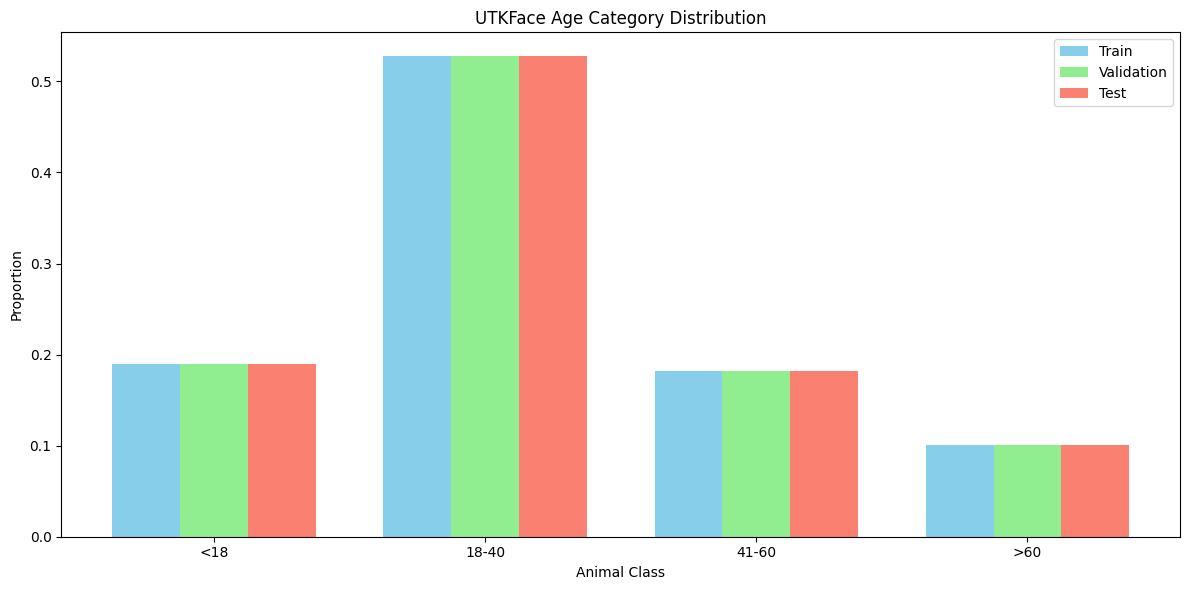

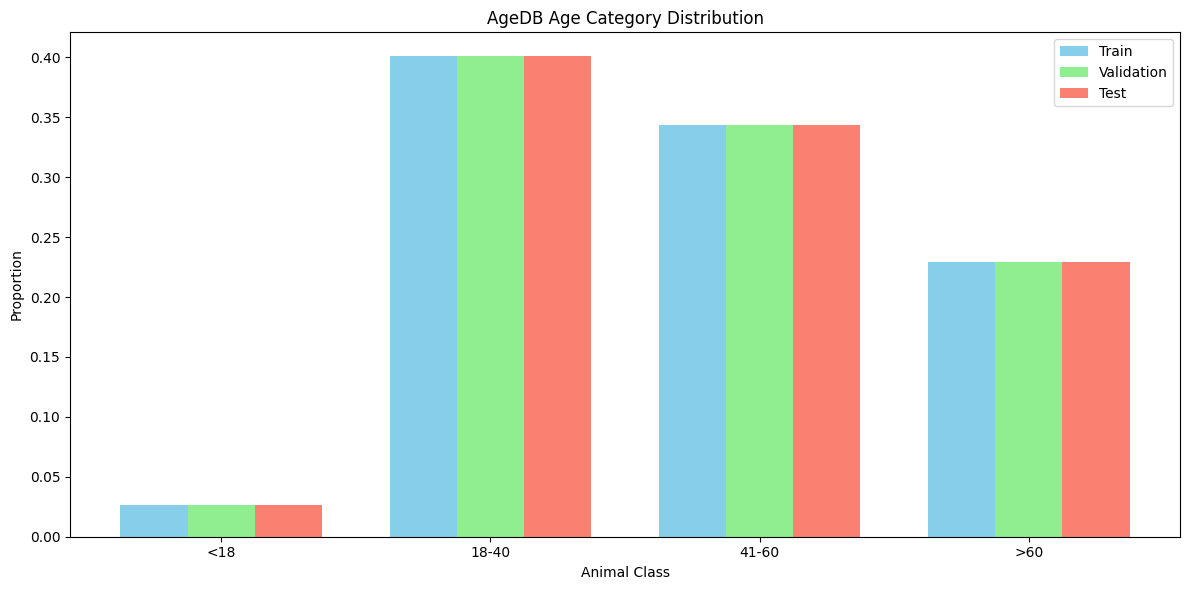

In [6]:
# Create train-test splits (for both datasets)
utkface_train_val_X, utkface_test_X, utkface_train_val_y, utkface_test_y = train_test_split(utkface_df['image_path'], utkface_df['age_category'], test_size=0.2, random_state=42, stratify=utkface_df['age_category'])
utkface_train_X, utkface_val_X, utkface_train_y, utkface_val_y = train_test_split(utkface_train_val_X, utkface_train_val_y, test_size=0.25, shuffle=True, random_state=42, stratify=utkface_train_val_y)
# Plot class distribution for UTKFace
plot_class_distribution(utkface_train_y, utkface_val_y, utkface_test_y, title="UTKFace Age Category Distribution")

agedb_train_val_X, agedb_test_X, agedb_train_val_y, agedb_test_y = train_test_split(agedb_df['image_path'], agedb_df['age_category'], test_size=0.2, random_state=42, stratify=agedb_df['age_category'])
agedb_train_X, agedb_val_X, agedb_train_y, agedb_val_y = train_test_split(agedb_train_val_X, agedb_train_val_y, test_size=0.25, shuffle=True, random_state=42, stratify=agedb_train_val_y)
# Plot class distribution for AgeDB
plot_class_distribution(agedb_train_y, agedb_val_y, agedb_test_y, title="AgeDB Age Category Distribution")

Create class_weights (later for the loss function) to deal with unbalanced classes:

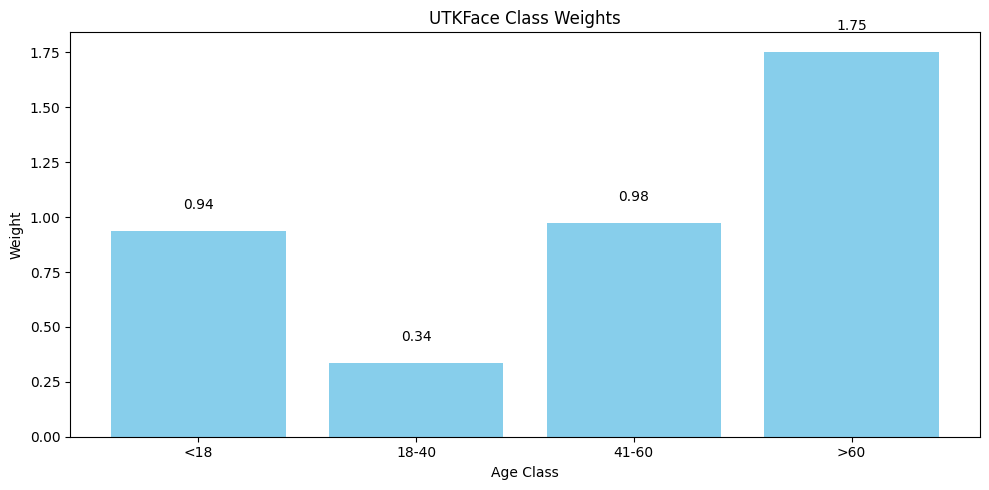

Class weights tensor: tensor([0.9350, 0.3361, 0.9752, 1.7537], device='cuda:0')


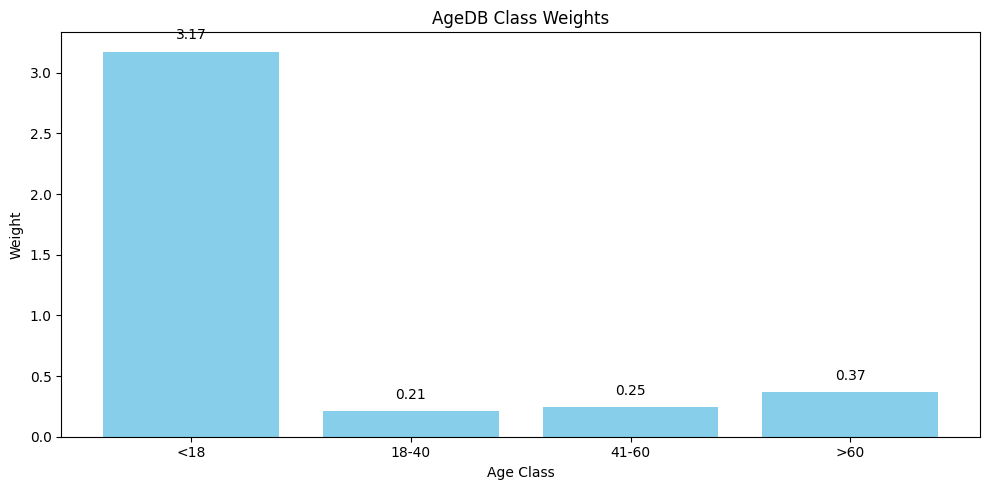

Class weights tensor: tensor([3.1750, 0.2106, 0.2456, 0.3688], device='cuda:0')


In [7]:
# Create class weights for both datasets
utkface_class_weights = create_class_weights(utkface_train_y, 4)
plot_class_weights(utkface_class_weights, utkface_train_y, title="UTKFace Class Weights")
# Convert class weights to a pytorch tensor
utkface_class_weights_tensor = torch.FloatTensor(utkface_class_weights).to(device)
print("Class weights tensor:", utkface_class_weights_tensor)

agedb_class_weights = create_class_weights(agedb_train_y, 4)
plot_class_weights(agedb_class_weights, agedb_train_y, title="AgeDB Class Weights")
# Convert class weights to a pytorch tensor
agedb_class_weights_tensor = torch.FloatTensor(agedb_class_weights).to(device)
print("Class weights tensor:", agedb_class_weights_tensor)


Create Datasets from both splits:

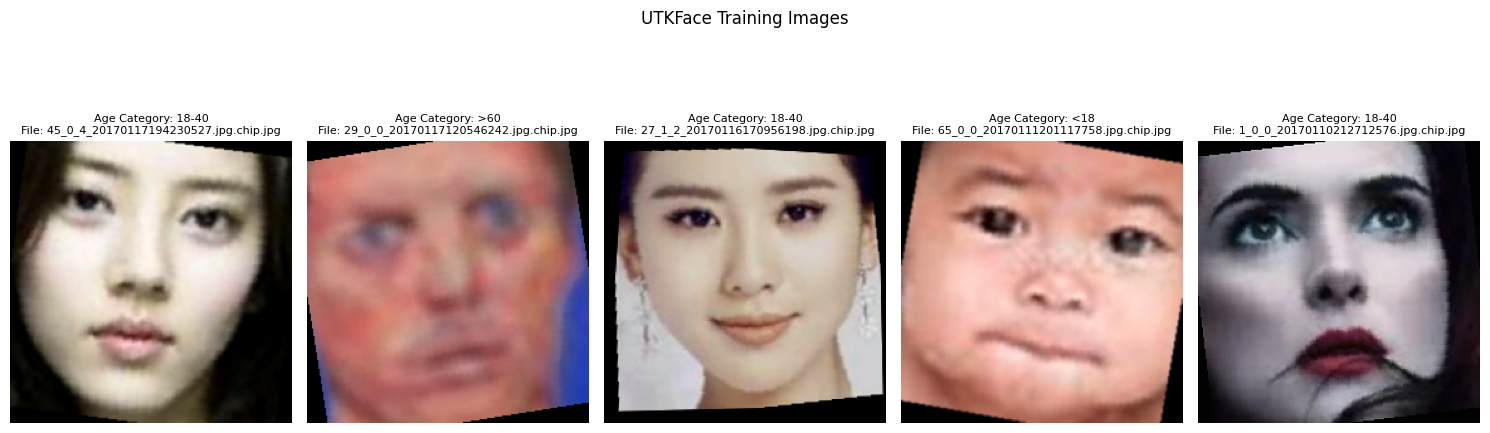

Hint: The paths of the training images are not matching, because the dataloader was shuffled. This is expected behavior.


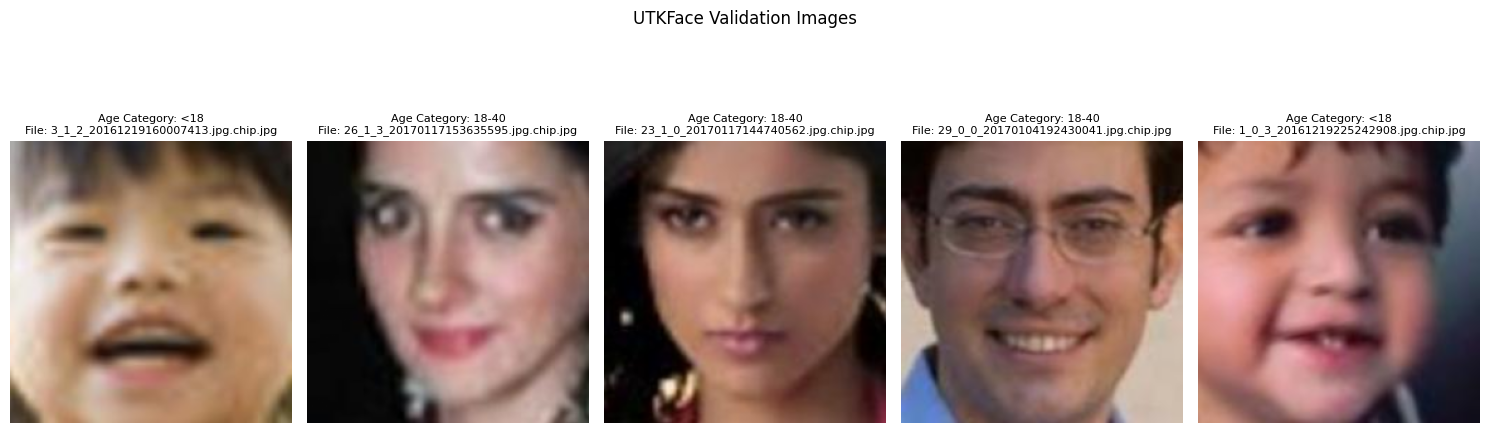

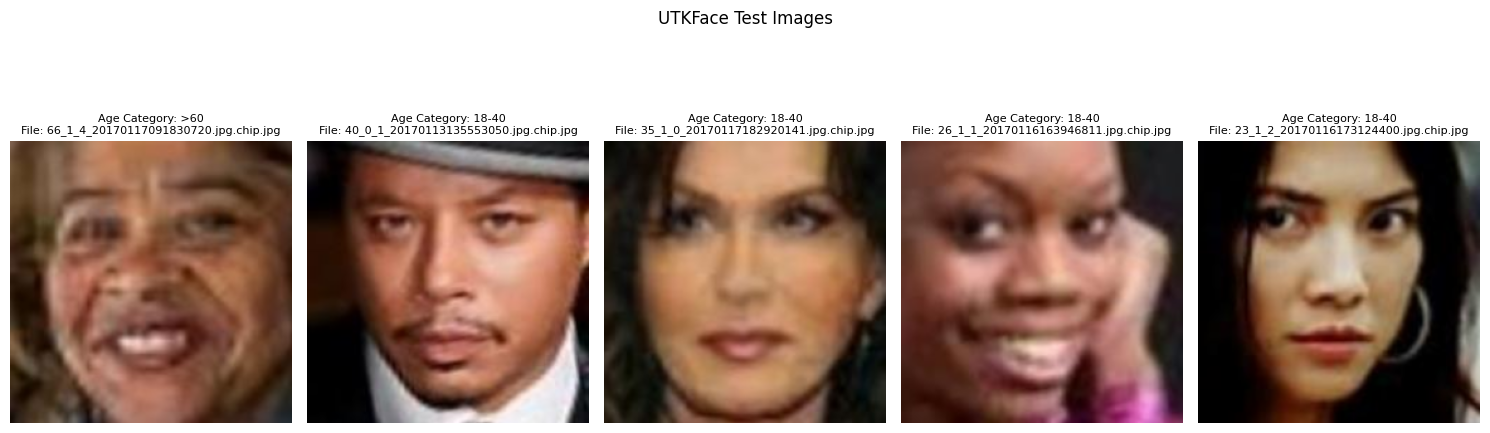

In [8]:
# Create dataloader for both datasets
utkface_train_dataset, utkface_train_loader = create_datasets_loader(X=utkface_train_X, y=utkface_train_y, transform=transform_train, batch_size=256, shuffle=True, num_workers=0)
utkface_val_dataset, utkface_val_loader = create_datasets_loader(X=utkface_val_X, y=utkface_val_y, transform=transform_test, batch_size=256, shuffle=False, num_workers=0)
utkface_test_dataset, utkface_test_loader = create_datasets_loader(X=utkface_test_X, y=utkface_test_y, transform=transform_test, batch_size=256, shuffle=False, num_workers=0)

plot_images_with_labels_and_filenames(data_loader=utkface_train_loader, dataset=utkface_train_dataset, num_images=5, title="UTKFace Training Images")
print("Hint: The paths of the training images are not matching, because the dataloader was shuffled. This is expected behavior.")
plot_images_with_labels_and_filenames(data_loader=utkface_val_loader, dataset=utkface_val_dataset, num_images=5, title="UTKFace Validation Images")
plot_images_with_labels_and_filenames(data_loader=utkface_test_loader, dataset=utkface_test_dataset, num_images=5, title="UTKFace Test Images")

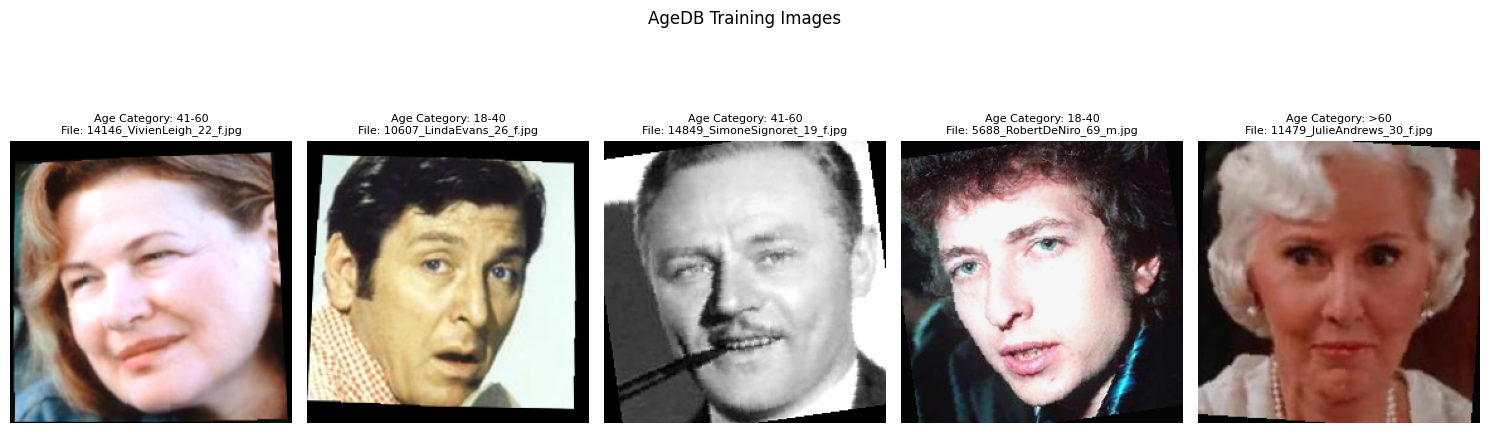

Hint: The paths of the training images are not matching, because the dataloader was shuffled. This is expected behavior.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


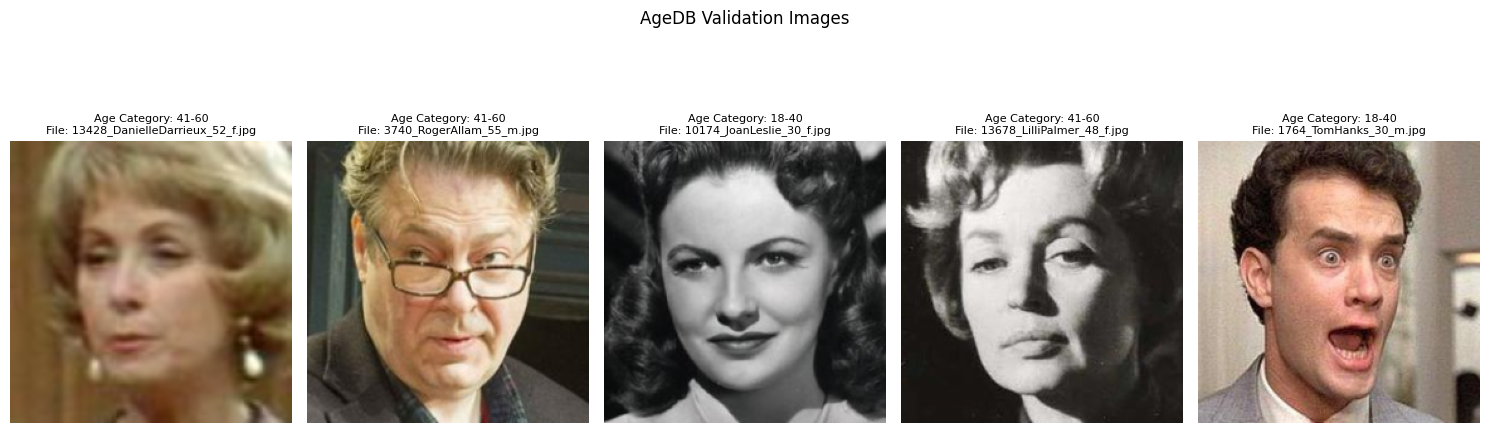

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


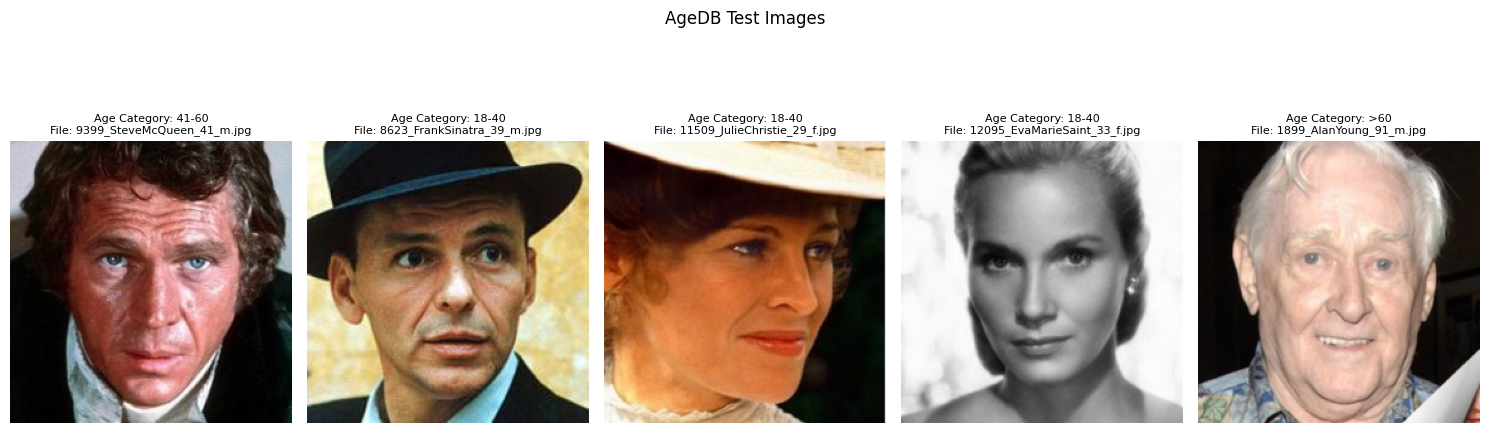

In [9]:

agedb_train_dataset, agedb_train_loader = create_datasets_loader(X=agedb_train_X, y=agedb_train_y, transform=transform_train, batch_size=256, shuffle=True, num_workers=0)
agedb_val_dataset, agedb_val_loader = create_datasets_loader(X=agedb_val_X, y=agedb_val_y, transform=transform_test, batch_size=256, shuffle=False, num_workers=0)
agedb_test_dataset, agedb_test_loader = create_datasets_loader(X=agedb_test_X, y=agedb_test_y, transform=transform_test, batch_size=256, shuffle=False, num_workers=0)

plot_images_with_labels_and_filenames(agedb_train_loader, agedb_train_dataset, num_images=5, title="AgeDB Training Images")
print("Hint: The paths of the training images are not matching, because the dataloader was shuffled. This is expected behavior.")
plot_images_with_labels_and_filenames(agedb_val_loader, agedb_val_dataset, num_images=5, title="AgeDB Validation Images")
plot_images_with_labels_and_filenames(agedb_test_loader, agedb_test_dataset, num_images=5, title="AgeDB Test Images")

## 3. Build CoAtNet

TODO:
- [ ] import via timm (the model already exists there)
- [ ] adjust for pre-training
- [ ] adjust for fine-tuning

In [10]:
images, labels = next(iter(utkface_train_loader))
num_classes = 4
in_channels = images.shape[1]

print(f"Number of classes: {num_classes}")
print(f"Number of channels: {in_channels}")

# base_model = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=4)

Number of classes: 4
Number of channels: 3


> IMPORTANT: the CoAtNet needs a lot of computing power. I preselected the `coatnet_0_224`, because it's the basic Net described in the paper. But there are some variants `coatnet_nano_rw_224` and `coatnet_pico_rw_224`, that are smaller, but with some differences in the architecture. **We MUST decide, what kind of CoAtNet we want to use**

> If you have problems with the training, try to **reduce the batch_size**.

In [11]:
# List all available models in timm
timm.list_models("coatnet*", pretrained=False)

model = timm.create_model("coatnet_0_224", pretrained=False, num_classes=num_classes, in_chans=in_channels)

print(model)

print(f"Base Model trainable parameters: {get_parameters(model)}")

MaxxVit(
  (stem): Stem(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (norm1): BatchNormAct2d(
      64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): GELU()
    )
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (stages): Sequential(
    (0): MaxxVitStage(
      (blocks): Sequential(
        (0): MbConvBlock(
          (shortcut): Downsample2d(
            (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
            (expand): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1))
          )
          (pre_norm): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Identity()
          )
          (down): Identity()
          (conv1_1x1): Conv2d(64, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm1): BatchNormAct2d(
          

> **How to modify an `timm.model`**: [Guide](https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055-2/)

## 4. Pre-Training

> Hint 1: Use the dataloader created in [Load and prepare Datasets](#2-load-and-prepare-datasets)
> Hint 2: Use the `class_weights_tensor` for unbalanced classes created in [Load and prepare Datasets](#2-load-and-prepare-datasets)
> Hint 3: Use the base model created in [Build CoAtNet](#3-build-coatnet) and maybe adjust for your SSL approach

TODO:
- [x] adjust base model for SSL approach
- [x] prepare dataset for SimCLR
- [x] create train loop
- [x] train
- [x] save best run --> pre-trained model
- [x] evaluate

Create Dataset and Dataloader for SimCLR (pairs of images)

In [12]:
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]

# SimCLR Augmentation
transform_train_simclr = transforms.Compose([
                # Convert to PIL Image for compatibility with torchvision transforms
                v2.ToImage(),
                v2.RandomResizedCrop(size=224, scale=(0.2, 1.0)),
                v2.RandomHorizontalFlip(p=0.5),
                v2.RandomApply([
                    v2.ColorJitter(brightness=0.8*0.5, contrast=0.8*0.5,
                                           saturation=0.8*0.5, hue=0.2*0.5)
                ], p=0.8),
                v2.RandomGrayscale(p=0.2),
                # Make kernel_size adaptive to image size with min 3x3, helps the blur augmentation be consistently effective without being too weak or too strong.
                v2.RandomApply([
                    v2.GaussianBlur(kernel_size=max(3, 224//20*2+1), sigma=(0.1, 2.0))
                ], p=0.5),

                # Normalization
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
            ])

# Minimal augmentation for validation because still need two views for SimCLR loss
transform_test_simclr = transforms.Compose([
                # Convert to PIL Image for compatibility with torchvision transforms
                v2.ToImage(),
                v2.RandomResizedCrop(size=224, scale=(0.8, 1.0)), # Less aggressive crop
                v2.RandomHorizontalFlip(p=0.5),
                v2.RandomGrayscale(p=0.1),

                # Normalization
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
            ])

simclr_train_dataset, simclr_train_loader = create_datasets_loader_simclr(X=utkface_train_X, y=utkface_train_y, transform=transform_train_simclr, batch_size=32, shuffle=True, num_workers=0)
simclr_val_dataset, simclr_val_loader = create_datasets_loader_simclr(X=utkface_val_X, y=utkface_val_y, transform=transform_test_simclr, batch_size=32, shuffle=False, num_workers=0)
simclr_test_dataset, simclr_test_loader = create_datasets_loader_simclr(X=utkface_test_X, y=utkface_test_y, transform=transform_test_simclr, batch_size=32, shuffle=False, num_workers=0)

Define adjustments for the base CoAtNet model

In [13]:
# Taken from https://github.com/hamkerlab/DL_for_practitioners/blob/main/06_1_SSL_SimCLR/06_1_SSL_SimCLR.ipynb
class LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, use_bias=True, use_bn=False, **kwargs):
        super(LinearLayer, self).__init__(**kwargs)
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        self.use_bn = use_bn
        self.linear = nn.Linear(self.in_features, self.out_features, bias=self.use_bias and not self.use_bn)
        if self.use_bn:
            self.bn = nn.BatchNorm1d(self.out_features)
    def forward(self, x):
        x = self.linear(x)
        if self.use_bn:
            x = self.bn(x)
        return x


# Taken from https://github.com/hamkerlab/DL_for_practitioners/blob/main/06_1_SSL_SimCLR/06_1_SSL_SimCLR.ipynb
class ProjectionHead(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, head_type='nonlinear', **kwargs):
        super(ProjectionHead, self).__init__(**kwargs)
        # ... (same as before) ...
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_features = hidden_features
        self.head_type = head_type

        if self.head_type == 'linear':
            self.layers = LinearLayer(self.in_features, self.out_features, False, True)
        elif self.head_type == 'nonlinear': # Standard for SimCLR
            self.layers = nn.Sequential(
                LinearLayer(self.in_features, self.hidden_features, True, True),
                nn.ReLU(),
                LinearLayer(self.hidden_features, self.out_features, False, True)
            )
    def forward(self, x):
        x = self.layers(x)
        return x
    
class SimCLRCoAtNetModel(nn.Module):
    def __init__(self, coatnet_model_name, projection_out_features):
        super().__init__()
        # num_classes=0 = no need for final classification layer.
        self.encoder = timm.create_model(coatnet_model_name, pretrained=False, num_classes=0)

        # Get feature dimension from CoAtNet
        coanet_feature_dim = self.encoder.num_features
        print(f"CoAtNet ('{coatnet_model_name}') output feature dimension: {coanet_feature_dim}")

        # Projection Head
        self.projector = ProjectionHead(
            in_features=coanet_feature_dim,
            hidden_features=coanet_feature_dim,
            out_features=projection_out_features
        )

    def forward(self, x):
        h = self.encoder(x) # Features from CoAtNet: [batch_size, coanet_feature_dim]
        if h.ndim > 2: # Should already be [batch_size, coanet_feature_dim] from timm with num_classes=0
            h = torch.squeeze(h)
        z = self.projector(h) # Projected features: [batch_size, projection_out_features]
        return z # For SimCLR pre-training, only z is needed for loss calculation

model = SimCLRCoAtNetModel(coatnet_model_name="coatnet_0_224", projection_out_features=128).to(device)
print(model)

CoAtNet ('coatnet_0_224') output feature dimension: 768
SimCLRCoAtNetModel(
  (encoder): MaxxVit(
    (stem): Stem(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm1): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): GELU()
      )
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (stages): Sequential(
      (0): MaxxVitStage(
        (blocks): Sequential(
          (0): MbConvBlock(
            (shortcut): Downsample2d(
              (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
              (expand): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1))
            )
            (pre_norm): BatchNormAct2d(
              64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Identity()
            )
            (down): Identit

Prepare pre-training setup
- Loss Function
- Optimizer
- Scheduler

In [14]:
LEARNING_RATE = 0.3 * (32 / 256.0)
WEIGHT_DECAY = 1e-6 # From notebook and SimCLR paper
EPOCHS = 5 # 5
# 10% of total epochs for self-supervised ViT
# Source Caron et al. (2021) "Emerging Properties in Self-Supervised Vision Transformers" 
WARMUP_EPOCHS = max(1, int(0.10 * EPOCHS))

criterion = SimCLR_Loss(batch_size=32, temperature=0.1).to(device)

optimizer = LARS(
    [params for params in model.parameters() if params.requires_grad],
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)

scheduler_warmup = torch.optim.lr_scheduler.LambdaLR(
     optimizer,
     lambda epoch: (epoch + 1) / WARMUP_EPOCHS if WARMUP_EPOCHS > 0 else 1.0) # Ensure it stays 1.0 after warmup

# Cosine Decay (NO restarts for a single run)
scheduler_cosine_decay = torch.optim.lr_scheduler.CosineAnnealingLR(
                            optimizer,
                            T_max=EPOCHS - WARMUP_EPOCHS,
                            eta_min=1e-6, # minimum learning rate from guidelines in [1]
                            last_epoch=-1)

combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer,
                                  schedulers=[scheduler_warmup, scheduler_cosine_decay],
                                  milestones=[WARMUP_EPOCHS])

Start pre-training

In [ ]:
with timer("Pre-Training SimCLR"):
    # Pre-training loop
    history = train_model_simclr(model=model,
                                 train_loader=simclr_train_loader,
                                 val_loader=simclr_val_loader,
                                 criterion=criterion,
                                 optimizer=optimizer,
                                 scheduler=combined_scheduler,
                                 device=device,
                                 num_epochs=EPOCHS,
                                 COATNET_MODEL_NAME="coatnet_0_224")

Starting SimCLR pre-training with coatnet_0_224 for 5 epochs...


Epoch 1/5 [Train]:   0%|          | 0/444 [00:00<?, ?it/s]/home/h4/nikh836h/dlfp_age_task/Utils/optimizers.py:129: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at /pytorch/torch/csrc/utils/python_arg_parser.cpp:1691.)
  next_v.mul_(momentum).add_(scaled_lr, grad)
Epoch 1/5 [Train]:  19%|█▊        | 83/444 [00:35<02:15,  2.66it/s, Loss=5.2] 

In [ ]:
simple_loss_plot(train_losses=history["train_loss"], val_losses=history["val_loss"], MODEL_NAME="coatnet_pretrained", title="SimCLR Pre-Training Loss")

# Visualize embeddings with t-SNE
# Instantiate the encoder architecture
PATH_TO_BEST_ENCODER_WEIGHTS = f'./coatnet_0_224_simclr_encoder_best_val_loss.pth'
feature_extractor_for_tsne = timm.create_model("coatnet_0_224", pretrained=False, num_classes=0)

class_names_list = ["<18", "18-40", "41-60", ">60"]

# Load the weights of the "best" encoder
if os.path.exists(PATH_TO_BEST_ENCODER_WEIGHTS):
    feature_extractor_for_tsne.load_state_dict(torch.load(PATH_TO_BEST_ENCODER_WEIGHTS, map_location=device))
    print(f"Loaded best encoder weights from {PATH_TO_BEST_ENCODER_WEIGHTS} for t-SNE.")
    feature_extractor_for_tsne.to(device)
    feature_extractor_for_tsne.eval()

    if simclr_test_dataset is not None and not simclr_test_dataset.empty:
        tsne_sample_size = len(simclr_test_dataset)  # Number of samples for t-SNE
        print(f"Using {tsne_sample_size} samples from validation set for t-SNE.")

        # TODO: might need even a more minimal transform!!
        feature_dataset = simclr_test_dataset
        feature_loader = simclr_test_loader

        all_features = []
        all_labels_for_tsne = []

        with timer("Evaluation of pre-trained net for t-SNE"):
            with torch.no_grad():
                for x_i_batch, x_j_batch, labels_batch  in tqdm(feature_loader, desc="Extracting features for t-SNE"):
                    images = x_i_batch.to(device)
                    # Get 'h' from encoder?
                    features = feature_extractor_for_tsne(images)
                    all_features.append(features.cpu())
                    all_labels_for_tsne.append(labels_batch.cpu())

        if all_features:
            all_features_tensor = torch.cat(all_features, dim=0)
            all_labels_tensor = torch.cat(all_labels_for_tsne, dim=0)

            visualize_embeddings_tsne(
                embeddings=all_features_tensor,
                labels=all_labels_tensor,
                output_dir="./tsne_plots",
                class_names=class_names_list,
                n_samples=tsne_sample_size,
                title_suffix=f" after {EPOCHS} Epochs SimCLR"
            )
        else:
            print("No features extracted for t-SNE.")
    else:
        print("Validation DataFrame (simclr_test_dataset) is empty or None!! ")

## 5. Fine-Tuning

> Hint 1: Use the dataloader created in [Load and prepare Datasets](#2-load-and-prepare-datasets)
> Hint 2: Use the `class_weights_tensor` for unbalanced classes created in [Load and prepare Datasets](#2-load-and-prepare-datasets)
> Hint 3: Use the pre-trained model created in [Build CoAtNet](#3-build-coatnet) and maybe adjust for the classification task

TODO:
- [ ] adjust pre-trained model for classification head
- [ ] create train loop
- [ ] train
- [ ] save best run --> final fine-tuned model
- [ ] evaluate (with our images)

In [ ]:
PATH_TO_BEST_ENCODER_WEIGHTS = f'./Best_val_loss.pth'

new_model = SimCLRCoAtNetModel(coatnet_model_name="coatnet_0_224", projection_out_features=256).to(device)
new_model.encoder.load_state_dict(torch.load(PATH_TO_BEST_ENCODER_WEIGHTS, map_location=device))


In [ ]:
class FineTuneModel(nn.Module):
    def __init__(self,base_model, num_classes, freeze_base = False):
        
        super().__init__()
        self.base_model = base_model
        ## freeze the pre-trained model if necessary
        if freeze_base:
            self.base_model.requires_grad_(False)
        else:
            self.base_model.requires_grad_(True)

        
        in_features = self.base_model.projector.out_features
        self.base_model.projector = LinearLayer(768, 256, False)
        ## new head for the classification
        self.new_head = nn.Sequential(nn.Linear(in_features, 256),
                                       nn.ReLU(),
                                       nn.Dropout(0.3),
                                       nn.Linear(256, num_classes))
        
    
    def forward(self,x):
        out = self.base_model(x)
        new_out = self.new_head(out)
        return new_out

In [ ]:
age_model = FineTuneModel(new_model, num_classes, freeze_base=True)

print('Trainable Parameters in network: %.3fM' % get_parameters(age_model))

num_epochs=15
init_lr= 1e-4
fine_optimizer = optim.AdamW(age_model.parameters(), lr=init_lr, weight_decay=5e-4)
fine_criterion = nn.CrossEntropyLoss(weight=utkface_class_weights_tensor)

In [ ]:
with timer("Fine Tune Training Loss"):
    # Fine tune training loop
    fine_tuned_history = train_model(model=age_model,
                                 train_loader=utkface_train_loader,
                                 val_loader=utkface_val_loader ,
                                 criterion=fine_criterion,
                                 optimizer=fine_optimizer,
                                 scheduler=combined_scheduler,
                                 device=device,
                                 num_epochs=num_epochs,
                                 checkpoint_path='Fine',
                                 patience=5,
                                 min_delta=0.001,
                                 monitor='val_loss')

In [ ]:
simple_loss_plot(train_losses=fine_tuned_history["train_loss"], val_losses=fine_tuned_history["val_loss"], MODEL_NAME="coatnet_fine_tuned", title="Fine Tune Training Loss")

In [ ]:
cm = confusion_matrix(fine_tuned_history['true_labels'], fine_tuned_history['predicted_labels'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<18", "18-40", "41-60", ">60"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_result.png")
plt.show()